# Cars prices detection

The "Not Damaged, Not Repainted" used car sales service is developing an application to attract new customers. The application will allow users to quickly determine the market value of their cars. You have access to historical data, including technical specifications, configurations, and prices of cars. Your task is to build a model for determining the cost.

The client's priorities are:

- Prediction quality
- Prediction speed
- Training time

## Data Preprocessing

Import of the used libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor, BayesianRidge, LassoLars
from sklearn.linear_model import ARDRegression, PassiveAggressiveRegressor, TheilSenRegressor, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

import random
import time
import warnings

Open dataset and save it in a dataframe `autos`

In [2]:
autos = pd.read_csv('autos.csv')

In [3]:
autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Let's remove the features that are useless for training the future model.

In [5]:
autos = autos.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)
autos = autos[autos['Price'] != 0]
autos = autos[(autos['RegistrationYear'] > 1900) & (autos['RegistrationYear'] <= 2020)]

In [6]:
autos.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


We will replace missing values in important features with placeholders.

In [7]:
autos[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired']] = \
autos[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired']].fillna('unk')

In [8]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343458 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              343458 non-null  int64 
 1   VehicleType        343458 non-null  object
 2   RegistrationYear   343458 non-null  int64 
 3   Gearbox            343458 non-null  object
 4   Power              343458 non-null  int64 
 5   Model              343458 non-null  object
 6   Kilometer          343458 non-null  int64 
 7   RegistrationMonth  343458 non-null  int64 
 8   FuelType           343458 non-null  object
 9   Brand              343458 non-null  object
 10  Repaired           343458 non-null  object
dtypes: int64(5), object(6)
memory usage: 31.4+ MB


Let's examine outliers and anomalies by visualizing the data using a box plot.

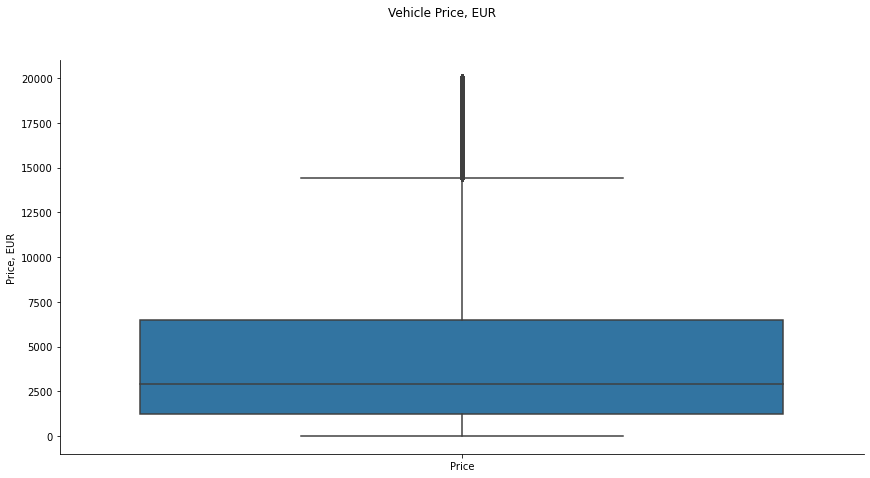

In [9]:
plot = sns.catplot(data=pd.DataFrame(autos['Price']), kind='box', height=6, 
                    aspect=2, legend_out=False)
plot.set_axis_labels(y_var='Price, EUR')
plot.set
plot.fig.suptitle('Vehicle Price, EUR', y=1.1);

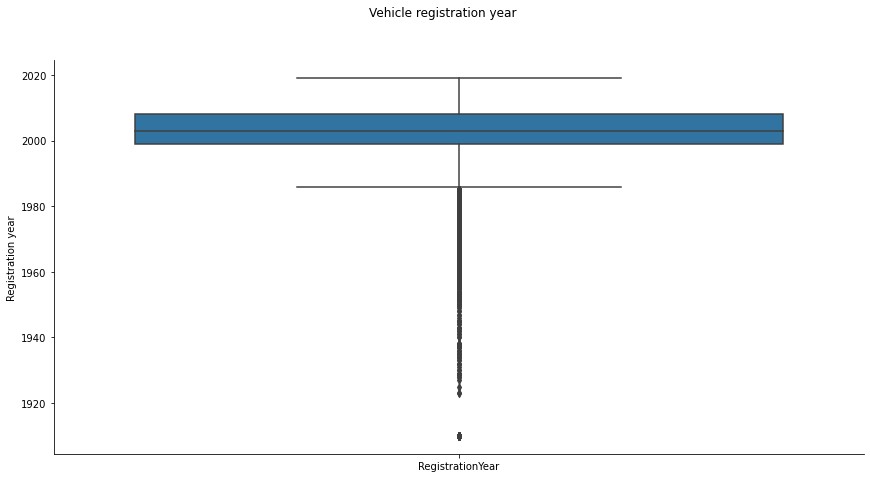

In [10]:
plot = sns.catplot(data=pd.DataFrame(autos['RegistrationYear']), kind='box', height=6, 
                    aspect=2, legend_out=False)
plot.set_axis_labels(y_var='Registration year')
plot.set
plot.fig.suptitle('Vehicle registration year', y=1.1);

In [11]:
iqr = autos['RegistrationYear'].describe()[6] - autos['RegistrationYear'].describe()[4]
cutting_point = autos['RegistrationYear'].describe()[4] - 3 * iqr
cutting_point

1972.0

Are there really so many cars produced abnormally long time ago?

In [12]:
autos[autos['RegistrationYear'] < cutting_point].describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000
mean,7561.169329,1962.260064,70.719489,77408.945687,4.163578
std,5855.645462,12.739199,414.861284,52152.934380,3.539521
min,1.000000,1910.000000,0.000000,5000.000000,0.000000
25%,2500.000000,1960.000000,0.000000,30000.000000,1.000000
50%,6500.000000,1966.000000,34.000000,80000.000000,4.000000
75%,12000.000000,1970.000000,76.000000,125000.000000,7.000000
max,20000.000000,1971.000000,16051.000000,150000.000000,12.000000


There aren't actually many objects with such an early year of production, but there is a significant price range. It would be better not to use this data for training the model.

In [13]:
autos = autos[autos['RegistrationYear'] >= cutting_point]

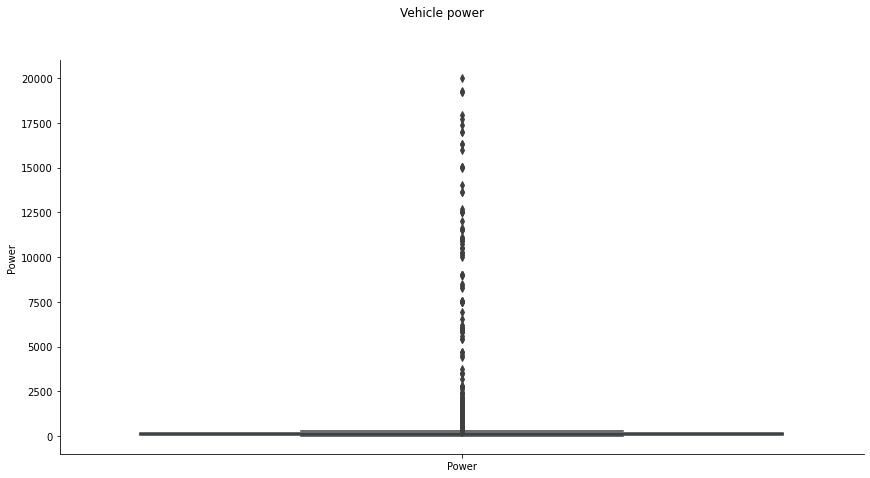

In [14]:
plot = sns.catplot(data=pd.DataFrame(autos['Power']), kind='box', height=6, 
                    aspect=2, legend_out=False)
plot.set_axis_labels(y_var='Power')
plot.set
plot.fig.suptitle('Vehicle power', y=1.1);

In [15]:
iqr = autos['Power'].describe()[6] - autos['Power'].describe()[4]
cutting_point = autos['Power'].describe()[6] + 3 * iqr
cutting_point

365.0

In [16]:
#посмотрим, сколько аномально мощных машин?
autos[autos['Power'] > cutting_point].count()['Power']

965

In [17]:
autos['Power'] = autos['Power'].map(lambda x: x if x <= cutting_point else 0)
autos[autos['Power'] > cutting_point].count()['Power']

0

Now what about the mileage?

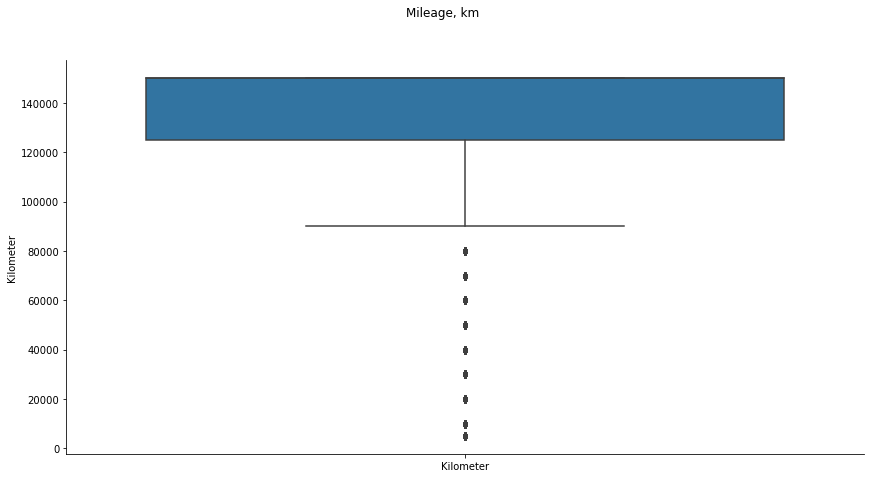

In [18]:
plot = sns.catplot(data=pd.DataFrame(autos['Kilometer']), kind='box', height=6, 
                    aspect=2, legend_out=False)
plot.set_axis_labels(y_var='Kilometer')
plot.set
plot.fig.suptitle('Mileage, km', y=1.1);

Выглядит неплохо, на рынке всегда будут автомобили с большим разбросом пробега.

In [19]:
autos.reset_index(drop=True)
autos


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,unk,1993,manual,0,golf,150000,0,petrol,volkswagen,unk
1,18300,coupe,2011,manual,190,unk,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unk
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...,...
354363,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no
354365,2200,unk,2005,unk,0,unk,20000,1,unk,sonstige_autos,unk
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no


Time to delete the duplicates

In [20]:
print('Кол-во дубликатов:', autos[autos.duplicated()]['Price'].count())
print(autos.shape[0])
autos.drop_duplicates(inplace=True, ignore_index=True)
print(autos.shape[0])

Кол-во дубликатов: 26120
341893
315773


In [21]:
autos.nunique()

Price                3721
VehicleType             9
RegistrationYear       48
Gearbox                 3
Power                 358
Model                 251
Kilometer              13
RegistrationMonth      13
FuelType                8
Brand                  40
Repaired                3
dtype: int64

In [22]:
autos.pivot_table(index='RegistrationMonth', aggfunc='count')


,Brand,FuelType,Gearbox,Kilometer,Model,Power,Price,RegistrationYear,Repaired,VehicleType
RegistrationMonth,,,,,,,,,,
0,30675,30675,30675,30675,30675,30675,30675,30675,30675,30675
1,20794,20794,20794,20794,20794,20794,20794,20794,20794,20794
2,19153,19153,19153,19153,19153,19153,19153,19153,19153,19153
3,31040,31040,31040,31040,31040,31040,31040,31040,31040,31040
4,26616,26616,26616,26616,26616,26616,26616,26616,26616,26616
5,26230,26230,26230,26230,26230,26230,26230,26230,26230,26230
6,28316,28316,28316,28316,28316,28316,28316,28316,28316,28316
7,24523,24523,24523,24523,24523,24523,24523,24523,24523,24523
8,20286,20286,20286,20286,20286,20286,20286,20286,20286,20286


Let's replace the zero month of registration with a random number between 1 and 12.

In [23]:
def random_digit(row):
    month = row['RegistrationMonth']
    if month == 0:
        return random.randint(1, 12)
    else:
        return month

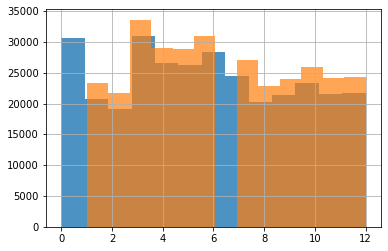

In [24]:
autos['RegistrationMonth'].hist(alpha=0.8, bins = 13);
autos['RegistrationMonth'] = autos.apply(random_digit, axis=1)
autos['RegistrationMonth'].hist(alpha=0.7, bins = 13);

In [25]:
autos['RegistrationMonth'].unique()

array([ 2,  5,  8,  6,  7, 10,  3, 12, 11,  1,  4,  9])

Once again the unique values:

In [26]:
my_list = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
for i in my_list:
    display(autos[i].unique())

array(['unk', 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

array(['manual', 'auto', 'unk'], dtype=object)

array(['golf', 'unk', 'grand', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'other', 'c4', 'civic',
       'transporter', 'punto', 'e_klasse', 'clio', 'kadett', 'kangoo',
       'one', 'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8',
       'jetta', 'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156',
       'escort', 'forester', 'xc_reihe', 'scenic', 'a4', 'ka', 'a1',
       'insignia', 'combo', 'focus', 'tt', 'corsa', 'a6', 'jazz', 'omega',
       'slk', '7er', '80', '147', '100', 'z_reihe', 'sportage', 'sorento',
       'v40', 'ibiza', 'mustang', 'eos', 'touran', 'getz', 'a3', 'almera',
       'megane', 'lupo', 'r19', 'zafira', 'caddy', 'mondeo', 'cordoba',
       'colt', 'impreza', 'vectra', 'berlingo', 'tiguan', 'i_reihe',
       'espace', 'sharan', '6_reihe', 'panda', 'up', 'seicento', 'ceed',
       '5_reihe', 'yeti', 'octavia', 'mii', 'rx_reihe', '6er', 'modus',
   

array(['petrol', 'gasoline', 'unk', 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'chrysler', 'jaguar', 'daewoo', 'porsche',
       'rover', 'saab', 'land_rover', 'lada'], dtype=object)

array(['unk', 'yes', 'no'], dtype=object)

There are no missing values, and the data has been preprocessed. Now let's prepare the features for training.
Let's divide all the features into categorical and numerical ones.

In [27]:
categorical = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand','Repaired','RegistrationMonth']
quantitive = ['Power', 'RegistrationYear', 'Kilometer']

Let's process the categorical features using OrdinalEncoder.

In [28]:
encoder = OrdinalEncoder()
encoder.fit(autos[categorical])
autos[categorical] = pd.DataFrame(encoder.transform(autos[categorical]), 
                                                            columns=autos[categorical].columns).astype('int64')

autos.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,7,1993,1,0,116,150000,1,6,38,1
1,18300,2,2011,1,190,228,125000,4,2,1,2
2,9800,6,2004,0,163,117,125000,7,2,14,1
3,1500,5,2001,1,75,116,150000,5,6,38,0
4,3600,5,2008,1,69,101,90000,6,2,31,0


We will be working with different models, so let's create two datasets: one encoded using the One-Hot Encoding (OHE) technique, and the other using ordinal encoding (autos_ord).

In [29]:
autos_ord = autos.copy()
autos_ohe = autos.copy()
autos_ohe = pd.get_dummies(data=autos_ohe, columns=categorical, drop_first=True)

Let's split the data into three datasets and separate the features (target - 'Price'):

In [30]:
x_autos_ord = autos_ord.drop('Price', axis=1)
y_autos_ord = autos_ord['Price']
x_autos_ohe = autos_ohe.drop('Price', axis=1)
y_autos_ohe = autos_ohe['Price']

In [31]:
x_autos_ohe_train, x_autos_ohe_val, x_autos_ohe_test= np.split(x_autos_ohe, [round (0.8*len(x_autos_ohe)),round (0.9*len(x_autos_ohe))])
y_autos_ohe_train, y_autos_ohe_val, y_autos_ohe_test= np.split(y_autos_ohe, [round (0.8*len(y_autos_ohe)),round (0.9*len(y_autos_ohe))])

x_autos_ord_train, x_autos_ord_val, x_autos_ord_test= np.split(x_autos_ord, [round (0.8*len(x_autos_ord)),round (0.9*len(x_autos_ord))])
y_autos_ord_train, y_autos_ord_val, y_autos_ord_test= np.split(y_autos_ord, [round (0.8*len(x_autos_ord)),round (0.9*len(x_autos_ord))])



In [32]:
x_autos_ord_train.shape, x_autos_ord_test.shape, y_autos_ord_train.shape, y_autos_ord_test.shape


((252618, 10), (31577, 10), (252618,), (31577,))

In [33]:
x_autos_ohe_train.shape, x_autos_ohe_test.shape, y_autos_ohe_train.shape, y_autos_ohe_test.shape


((252618, 322), (31577, 322), (252618,), (31577,))

Let's perform scaling on the numerical features:

In [34]:
scaler_ord = StandardScaler()

warnings.filterwarnings(action='ignore')

x_autos_ord_train.loc[:, quantitive] = scaler_ord.fit_transform(
    x_autos_ord_train.loc[:, quantitive])

x_autos_ord_test.loc[:, quantitive] = scaler_ord.transform(x_autos_ord_test.loc[:, quantitive])
x_autos_ord_val.loc[:, quantitive] = scaler_ord.transform(x_autos_ord_val.loc[:, quantitive])

warnings.filterwarnings(action='default')

display(x_autos_ord_train[quantitive].head())
display(x_autos_ord_val[quantitive].head())
display(x_autos_ord_test[quantitive].head())

,Power,RegistrationYear,Kilometer
0,-1.739985,-1.510408,0.576518
1,1.359434,1.117988,-0.092700
2,0.918990,0.095834,-0.092700
3,-0.516530,-0.342232,0.576518
4,-0.614406,0.679922,-1.029605


,Power,RegistrationYear,Kilometer
252618,-0.516530,-0.342232,0.576518
252619,0.706925,0.241856,0.576518
252620,1.392059,-1.510408,0.576518
252621,-0.027148,1.994120,0.576518
252622,-0.761221,-0.488254,0.576518


,Power,RegistrationYear,Kilometer
284196,0.478547,0.387878,0.576518
284197,-1.739985,0.533900,0.576518
284198,-0.092399,-0.926320,0.576518
284199,1.033179,-0.196210,0.576518
284200,-0.190275,0.241856,-0.092700


Same with OHE method

In [35]:
scaler_ohe = StandardScaler()

warnings.filterwarnings(action='ignore')

x_autos_ohe_train.loc[:, quantitive] = scaler_ohe.fit_transform(
    x_autos_ohe_train.loc[:, quantitive])

x_autos_ohe_test.loc[:, quantitive] = scaler_ohe.transform(x_autos_ohe_test.loc[:, quantitive])
x_autos_ohe_val.loc[:, quantitive] = scaler_ohe.transform(x_autos_ohe_val.loc[:, quantitive])

warnings.filterwarnings(action='default')

display(x_autos_ohe_train[quantitive].head())
display(x_autos_ohe_val[quantitive].head())
display(x_autos_ohe_test[quantitive].head())

,Power,RegistrationYear,Kilometer
0,-1.739985,-1.510408,0.576518
1,1.359434,1.117988,-0.092700
2,0.918990,0.095834,-0.092700
3,-0.516530,-0.342232,0.576518
4,-0.614406,0.679922,-1.029605


,Power,RegistrationYear,Kilometer
252618,-0.516530,-0.342232,0.576518
252619,0.706925,0.241856,0.576518
252620,1.392059,-1.510408,0.576518
252621,-0.027148,1.994120,0.576518
252622,-0.761221,-0.488254,0.576518


,Power,RegistrationYear,Kilometer
284196,0.478547,0.387878,0.576518
284197,-1.739985,0.533900,0.576518
284198,-0.092399,-0.926320,0.576518
284199,1.033179,-0.196210,0.576518
284200,-0.190275,0.241856,-0.092700


## Model Training

Let's start with the models available in the SKlearn library: linear regression, decision tree, and gradient boosting.

In [36]:
linear = [LinearRegression(normalize=True), LassoLars(normalize=False),
          PassiveAggressiveRegressor(random_state=12345)]
trees = [DecisionTreeRegressor(random_state=12345, max_depth=10)]
gb = [GradientBoostingRegressor(random_state=12345, n_estimators=1200, learning_rate=0.25)]

Separate dataframe for `results`:

In [37]:
results = pd.DataFrame({'Regressor' : [], 'CV RMSE score' : [], 'Train RMSE score' : [], 'Val RMSE score' : [], 
                        'Learning Time' : [], 'Prediction Time' : []})

For convenience, let's create a function for model training, including hyperparameter tuning. The function will take models and features as arguments, train them, and output the necessary metrics.

In [38]:
def learn_models(models_list, x_train, y_train, x_val, y_val, params={}, model='default', regr_name='', n_jobs=-1):
    

    for i in models_list:
        regr_gs = GridSearchCV(i, params, cv=5, scoring='neg_root_mean_squared_error')
        if model == 'default':
            regr_gs.fit(x_train,y_train)
        if model == 'catboost':
            regr_gs.fit(x_train,y_train, cat_features=categorical)
        elif model == 'lgb':
            regr_gs.fit(x_train,y_train, categorical_feature=categorical)
        else:
            regr_gs.fit(x_train,y_train)
            
        cv_score = regr_gs.best_score_
        
        regr = regr_gs.best_estimator_
        start_learning = time.time()
        if model == 'default':
            regr.fit(x_train,y_train)
        if model == 'catboost':
            regr.fit(x_train,y_train, cat_features=categorical)
        elif model == 'lgb':
            regr.fit(x_train,y_train, categorical_feature=categorical)
        else:
            regr.fit(x_train,y_train)
        
        end_learning = time.time()
        duration_learning = end_learning - start_learning

        train_rmse_score = mean_squared_error(y_train, regr.predict(x_train), squared=False)

        start_prediction = time.time()
        val_rmse_score = mean_squared_error(y_val, regr.predict(x_val), squared=False)
        end_prediction = time.time()
        duration_prediction = end_prediction - start_prediction
        if regr_name == '':
            name = str(i).split(sep='(')[0]
        else:
            name = regr_name

        globals()['results'] = globals()['results'].append({
            'Regressor' : name, 'CV RMSE score' : round(cv_score, 2), 'Train RMSE score' : round(train_rmse_score, 2), 
            'Val RMSE score' : round(val_rmse_score, 2), 'Learning Time' :  round(duration_learning, 2), 
            'Prediction Time' : round(duration_prediction, 2)}, ignore_index=True)


In [39]:
learn_models(linear, x_autos_ohe_train, y_autos_ohe_train, x_autos_ohe_val, y_autos_ohe_val)

/Users/ivanshurgalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/Users/ivanshurgalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklear

/Users/ivanshurgalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/var/folders/cy/1f9vz20x39s2ctm4tynllrt00000gn/T/ipykernel_35547/1754621628.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  globals()['results'] = globals()['results'].append({
/var/folders/cy/1f9vz20x39s2ctm4tynllrt00000gn/T/ipy

In [40]:
learn_models(trees, x_autos_ord_train, y_autos_ord_train, x_autos_ord_val, y_autos_ord_val)

/var/folders/cy/1f9vz20x39s2ctm4tynllrt00000gn/T/ipykernel_35547/1754621628.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  globals()['results'] = globals()['results'].append({


In [41]:
learn_models(gb, x_autos_ord_train, y_autos_ord_train, x_autos_ord_val, y_autos_ord_val, 
             regr_name='GradientBoostingRegressor')

/var/folders/cy/1f9vz20x39s2ctm4tynllrt00000gn/T/ipykernel_35547/1754621628.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  globals()['results'] = globals()['results'].append({


In [42]:
results

,Regressor,CV RMSE score,Train RMSE score,Val RMSE score,Learning Time,Prediction Time
0,LinearRegression,-2655.65,2650.67,2657.04,6.83,0.01
1,LassoLars,-2688.03,2684.93,2695.44,1.65,0.01
2,PassiveAggressiveRegressor,-2751.21,2765.68,2765.95,47.73,0.03
3,DecisionTreeRegressor,-2040.89,1948.79,2063.17,0.78,0.00
4,GradientBoostingRegressor,-1679.43,1612.01,1689.60,331.21,0.35


Check the LightGBM model metrics (apllied to two datasets)

In [43]:
lgb_regr = lgb.LGBMRegressor(n_estimators=1200, objective='root_mean_squared_error')
lgb_params = {'learning_rate': [0.1, 0.25]}

In [44]:
learn_models([lgb_regr], x_autos_ord_train, y_autos_ord_train, x_autos_ord_val, y_autos_ord_val, 
             params=lgb_params, regr_name='LGBMRegressor (ordinal)', n_jobs=1)

/var/folders/cy/1f9vz20x39s2ctm4tynllrt00000gn/T/ipykernel_35547/1754621628.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  globals()['results'] = globals()['results'].append({


In [45]:
learn_models([lgb_regr], x_autos_ohe_train, y_autos_ohe_train, x_autos_ohe_val, y_autos_ohe_val, 
             params=lgb_params, regr_name='LGBMRegressor (ohe)', n_jobs=1)

/var/folders/cy/1f9vz20x39s2ctm4tynllrt00000gn/T/ipykernel_35547/1754621628.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  globals()['results'] = globals()['results'].append({


In [46]:
warnings.filterwarnings(action='ignore')
learn_models([lgb_regr], x_autos_ord_train, y_autos_ord_train, x_autos_ord_val, y_autos_ord_val, 
             params=lgb_params, model='lgb', regr_name='LGBMRegressor (ordinal specified)', n_jobs=1)
warnings.filterwarnings(action='default')

In [47]:
results

,Regressor,CV RMSE score,Train RMSE score,Val RMSE score,Learning Time,Prediction Time
0,LinearRegression,-2655.65,2650.67,2657.04,6.83,0.01
1,LassoLars,-2688.03,2684.93,2695.44,1.65,0.01
2,PassiveAggressiveRegressor,-2751.21,2765.68,2765.95,47.73,0.03
3,DecisionTreeRegressor,-2040.89,1948.79,2063.17,0.78,0.00
4,GradientBoostingRegressor,-1679.43,1612.01,1689.60,331.21,0.35
5,LGBMRegressor (ordinal),-1612.22,1414.44,1613.99,11.11,0.31
6,LGBMRegressor (ohe),-1608.19,1460.11,1615.75,21.18,0.54
7,LGBMRegressor (ordinal specified),-1601.01,1347.45,1603.97,8.01,0.32


 CatBoost

In [48]:
cat_regr = CatBoostRegressor(iterations=1200, learning_rate=0.25, verbose=False)

In [49]:
learn_models([cat_regr], x_autos_ord_train, y_autos_ord_train, x_autos_ord_val, y_autos_ord_val, 
             regr_name='CatBoostRegressor (ordinal)')

/var/folders/cy/1f9vz20x39s2ctm4tynllrt00000gn/T/ipykernel_35547/1754621628.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  globals()['results'] = globals()['results'].append({


In [50]:
learn_models([cat_regr], x_autos_ohe_train, y_autos_ohe_train, x_autos_ohe_val, y_autos_ohe_val, 
             regr_name='CatBoostRegressor (ohe)')


/var/folders/cy/1f9vz20x39s2ctm4tynllrt00000gn/T/ipykernel_35547/1754621628.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  globals()['results'] = globals()['results'].append({


In [51]:
learn_models([cat_regr], x_autos_ord_train, y_autos_ord_train, x_autos_ord_val, y_autos_ord_val, model='catboost', 
             regr_name='CatBoostRegressor (ordinal specified)')

/var/folders/cy/1f9vz20x39s2ctm4tynllrt00000gn/T/ipykernel_35547/1754621628.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  globals()['results'] = globals()['results'].append({


In [52]:
results

,Regressor,CV RMSE score,Train RMSE score,Val RMSE score,Learning Time,Prediction Time
0,LinearRegression,-2655.65,2650.67,2657.04,6.83,0.01
1,LassoLars,-2688.03,2684.93,2695.44,1.65,0.01
2,PassiveAggressiveRegressor,-2751.21,2765.68,2765.95,47.73,0.03
3,DecisionTreeRegressor,-2040.89,1948.79,2063.17,0.78,0.00
4,GradientBoostingRegressor,-1679.43,1612.01,1689.60,331.21,0.35
5,LGBMRegressor (ordinal),-1612.22,1414.44,1613.99,11.11,0.31
6,LGBMRegressor (ohe),-1608.19,1460.11,1615.75,21.18,0.54
7,LGBMRegressor (ordinal specified),-1601.01,1347.45,1603.97,8.01,0.32
8,CatBoostRegressor (ordinal),-1626.92,1458.30,1625.79,24.22,0.01
9,CatBoostRegressor (ohe),-1612.94,1466.13,1617.75,27.43,0.05


## Model analisys 

Let's display a consolidated table with metrics and prediction times for the models.

In [53]:
results.sort_values('Val RMSE score', ascending=True)

,Regressor,CV RMSE score,Train RMSE score,Val RMSE score,Learning Time,Prediction Time
7,LGBMRegressor (ordinal specified),-1601.01,1347.45,1603.97,8.01,0.32
5,LGBMRegressor (ordinal),-1612.22,1414.44,1613.99,11.11,0.31
6,LGBMRegressor (ohe),-1608.19,1460.11,1615.75,21.18,0.54
9,CatBoostRegressor (ohe),-1612.94,1466.13,1617.75,27.43,0.05
8,CatBoostRegressor (ordinal),-1626.92,1458.30,1625.79,24.22,0.01
10,CatBoostRegressor (ordinal specified),-1627.01,1509.25,1630.83,86.91,0.13
4,GradientBoostingRegressor,-1679.43,1612.01,1689.60,331.21,0.35
3,DecisionTreeRegressor,-2040.89,1948.79,2063.17,0.78,0.00
0,LinearRegression,-2655.65,2650.67,2657.04,6.83,0.01
1,LassoLars,-2688.03,2684.93,2695.44,1.65,0.01


In [54]:
training_results=results

As per the project requirements, when selecting the optimal model, we should consider both prediction time and model quality based on the RMSE metric. The PassiveAggressiveRegressor model has shown the best result.

## Key Findings:

- The dataset consisted of information about used cars, and the goal was to determine their market value, was preprocessed by removing irrelevant features, handling missing values, and encoding categorical features.
- The numerical features were scaled to ensure consistency across different models.
- Several models were trained, including linear regression, decision tree, and gradient boosting.
- The Linear regression model exhibited the best performance in terms of both prediction time and RMSE metric.
 